In [1]:
import numpy as np
from mayavi import mlab
import trimesh

from bfieldtools.coil_optimize import optimize_streamfunctions
from bfieldtools.mesh_conductor import MeshConductor
from bfieldtools import sphtools

In [7]:
mlab.init_notebook('png')

Notebook initialized with png backend.


In [3]:
cyl = trimesh.load("cylinder_LR.stl")
coil = MeshConductor(mesh_obj=cyl, fix_normals=True,basis_name='suh', N_suh=100)

Calculating surface harmonics expansion...
Computing the laplacian matrix...
Computing the mass matrix...


In [4]:
sidelength = 0.5
n = 10
xx = np.linspace(-sidelength / 2, sidelength / 2, n)
yy = np.linspace(-sidelength / 2, sidelength / 2, n)
zz = np.linspace(-sidelength / 2, sidelength / 2, n)
X, Y, Z = np.meshgrid(xx, yy, zz, indexing="ij")

x = X.ravel()
y = Y.ravel()
z = Z.ravel()

target_points = np.array([x, y, z]).T

# Turn cube into sphere by rejecting points "in the corners"
target_points = (
    target_points[np.linalg.norm(target_points, axis=1) < sidelength / 2]
)


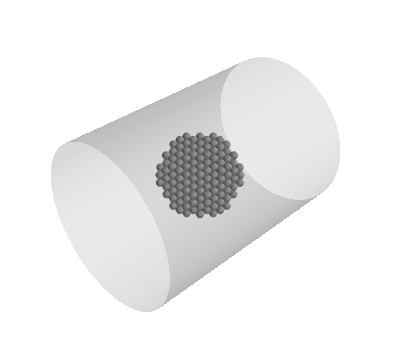

In [8]:
f = mlab.figure(bgcolor=(1, 1, 1), fgcolor=(.5, .5, .5))
mlab.points3d(*target_points.T)
coil.plot_mesh(opacity=0.2, figure=f)


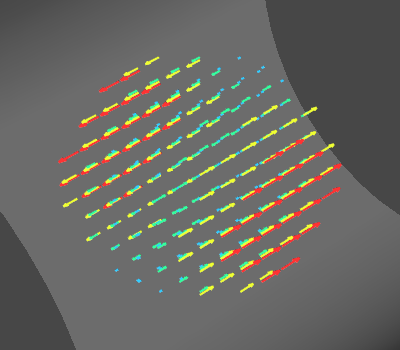

In [111]:
lmax = 2
alm = np.zeros((lmax * (lmax + 2),))
blm = np.zeros((lmax * (lmax + 2),))

# Set one specific component to one
blm[7] += 1


sphfield = sphtools.field(target_points, alm, blm, lmax)
target_field = sphfield / np.max(sphfield[:, 0])

field_y = target_field.copy()

field_y[:, 1] = 0
field_y[:, 2] = 0

mlab.clf()
f = mlab.figure(bgcolor=(.1, .1, .1), fgcolor=(1, 1, 1))
mlab.quiver3d(*target_points.T, *field_y.T, figure=f)
coil.plot_mesh(opacity=0.2, figure=f)
f.scene.isometric_view()
f.scene.camera.zoom(3)

# mlab.view(90, 180)
f

In [112]:
import mosek

target_spec = {
    "coupling": coil.B_coupling(target_points),
    "abs_error": 0.1,
    "target": target_field,
}

coil.s, prob = optimize_streamfunctions(
    coil,
    [target_spec],
    objective="minimum_inductive_energy",
    solver="MOSEK",
    solver_opts={"mosek_params": {mosek.iparam.num_threads: 8}},
)

Passing problem to solver...
                                     CVXPY                                     
                                     v1.2.1                                    
(CVXPY) Oct 06 09:33:16 PM: Your problem has 100 variables, 2 constraints, and 0 parameters.
(CVXPY) Oct 06 09:33:16 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 06 09:33:16 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 06 09:33:16 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 06 09:33:16 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Oct 06 09:33:16 PM: Reduction chain: Dcp2Cone -> CvxAttr2

Processing contour, value: -1759027.1848797149
Processing contour, value: -1488311.9867496637
Processing contour, value: -1217596.7886196126
Processing contour, value: -946881.5904895614
Processing contour, value: -676166.3923595103
Processing contour, value: -405451.19422945916
Processing contour, value: -134735.99609940802
Processing contour, value: 135979.20203064312
Processing contour, value: 406694.40016069403
Processing contour, value: 677409.5982907456
Processing contour, value: 948124.7964207963
Processing contour, value: 1218839.994550848
Processing contour, value: 1489555.1926808986
Processing contour, value: 1760270.3908109502



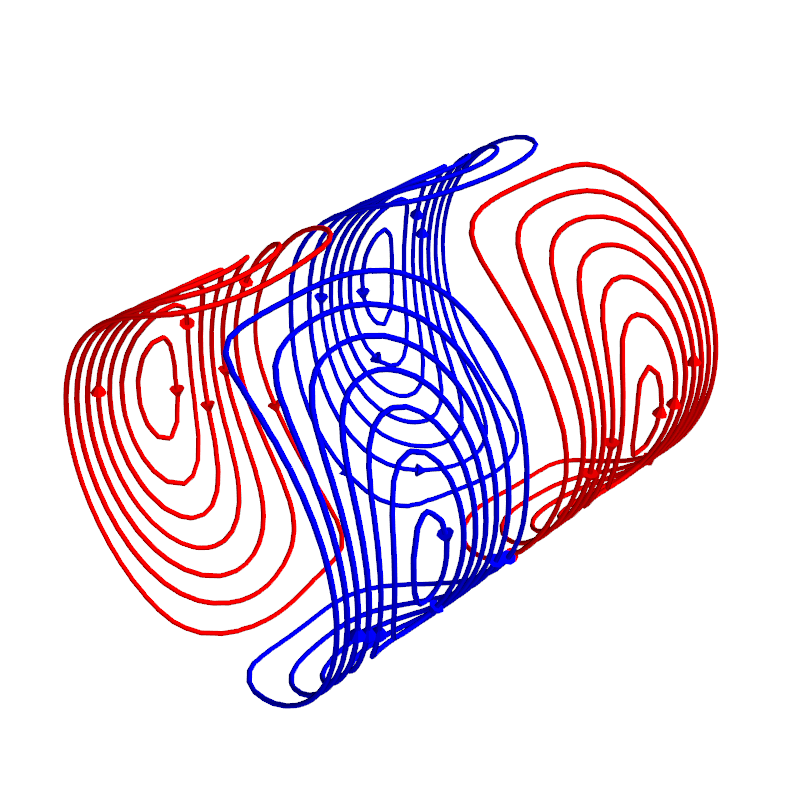

In [113]:
coil.s.discretize(N_contours=14).plot_loops()